1.Configuración del ambiente

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import yfinance as yf
from bs4 import BeautifulSoup
import requests
from IPython.display import clear_output
import datetime 
import pytz

2.Obtención de Datos

Precios históricos del bitcoin

In [2]:
# La biblioteca yfinance de Python permite extraer datos financieros de Yahoo Finance.

def importar_base_bitcoin():
  global df_bitcoin
  data = yf.Ticker("BTC-USD").history(period='7d', interval='5m')
  df_bitcoin = pd.DataFrame(data)
  return df_bitcoin

importar_base_bitcoin()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-18 00:00:00+00:00,28413.531250,28413.531250,28402.759766,28406.582031,0,0.0,0.0
2023-10-18 00:05:00+00:00,28410.611328,28437.593750,28410.611328,28437.593750,0,0.0,0.0
2023-10-18 00:10:00+00:00,28438.906250,28438.906250,28396.056641,28396.056641,0,0.0,0.0
2023-10-18 00:15:00+00:00,28387.884766,28436.150391,28387.884766,28436.150391,0,0.0,0.0
2023-10-18 00:20:00+00:00,28436.902344,28440.265625,28436.902344,28438.810547,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-10-24 01:55:00+00:00,33989.128906,34147.531250,33987.808594,34147.531250,167407616,0.0,0.0
2023-10-24 02:00:00+00:00,34166.652344,34354.492188,34166.652344,34354.492188,257470464,0.0,0.0
2023-10-24 02:05:00+00:00,34437.867188,34437.867188,34160.183594,34371.335938,242442240,0.0,0.0


Indicadores de tendencias

In [3]:
def extraer_tendencias():
    global precio_actual,tendencia
    url = 'https://coinmarketcap.com/'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    precio_btc = soup.find('div', class_='sc-a0353bbc-0 gDrtaY').get_text()
    precio_btc = precio_btc.replace(',', '')
    precio_btc = precio_btc.replace('$', '')
    precio_actual = float(precio_btc)
    icon = soup.findAll('span', {'class':['sc-d55c02b-0 iwhBxy','sc-97d6d2ca-0 bQjSqS']})[0]
    if 'sc-d55c02b-0 iwhBxy' in ' '.join(icon['class']):
        tendencia = 'alta'
    else:
        tendencia = 'baja'
    variacion = soup.find('span', class_='sc-d55c02b-0 iwhBxy').get_text()
    return [precio_actual, tendencia, variacion]

extraer_tendencias()

[34430.4, 'alta', '2.45%']

3.Limpieza de datos

In [4]:
def limpieza_datos():
  global media_bitcoin,df_bitcoin_limpio
  df = importar_base_bitcoin()
  df_bitcoin_limpio = df.copy()
  indices_unicos = df_bitcoin_limpio.index.drop_duplicates()
  df_bitcoin_limpio = df_bitcoin_limpio.reindex(indices_unicos)
  df_bitcoin_limpio.dropna(subset = ['Close'], inplace = True)
  df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]
  close = df_bitcoin_limpio['Close']
  Q1 = close.quantile(.25)
  Q3 = close.quantile(.75)
  IIQ = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IIQ
  limite_superior = Q3 + 1.5 * IIQ
  seleccion = ((close >= Q1) & (close < Q3))
  df_bitcoin_limpio = df_bitcoin_limpio[seleccion]

  return [df_bitcoin_limpio, Q1, Q3]

limpieza_datos()

[                                   Open          High           Low  \
 Datetime                                                              
 2023-10-18 04:55:00+00:00  28576.671875  28889.009766  28576.671875   
 2023-10-18 05:00:00+00:00  28735.289062  28752.898438  28698.828125   
 2023-10-18 05:05:00+00:00  28725.666016  28742.078125  28725.666016   
 2023-10-18 05:10:00+00:00  28741.804688  28741.804688  28701.523438   
 2023-10-18 05:25:00+00:00  28708.994141  28752.343750  28708.994141   
 ...                                 ...           ...           ...   
 2023-10-23 03:25:00+00:00  30369.308594  30409.542969  30369.308594   
 2023-10-23 03:30:00+00:00  30434.886719  30434.886719  30389.136719   
 2023-10-23 03:35:00+00:00  30396.970703  30421.216797  30390.947266   
 2023-10-23 09:45:00+00:00  30511.589844  30511.589844  30379.208984   
 2023-10-23 09:50:00+00:00  30421.076172  30458.980469  30421.076172   
 
                                   Close     Volume  Dividends

In [5]:
df_new = pd.DataFrame(df_bitcoin_limpio)

In [6]:
df_new

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-18 04:55:00+00:00,28576.671875,28889.009766,28576.671875,28727.962891,236791808,0.0,0.0
2023-10-18 05:00:00+00:00,28735.289062,28752.898438,28698.828125,28698.828125,454347776,0.0,0.0
2023-10-18 05:05:00+00:00,28725.666016,28742.078125,28725.666016,28742.078125,135631872,0.0,0.0
2023-10-18 05:10:00+00:00,28741.804688,28741.804688,28701.523438,28701.523438,47966208,0.0,0.0
2023-10-18 05:25:00+00:00,28708.994141,28752.343750,28708.994141,28744.191406,76482560,0.0,0.0
...,...,...,...,...,...,...,...
2023-10-23 03:25:00+00:00,30369.308594,30409.542969,30369.308594,30409.542969,36174848,0.0,0.0
2023-10-23 03:30:00+00:00,30434.886719,30434.886719,30389.136719,30393.720703,61370368,0.0,0.0
2023-10-23 03:35:00+00:00,30396.970703,30421.216797,30390.947266,30421.216797,21917696,0.0,0.0


In [7]:
sns.set(style="darkgrid")

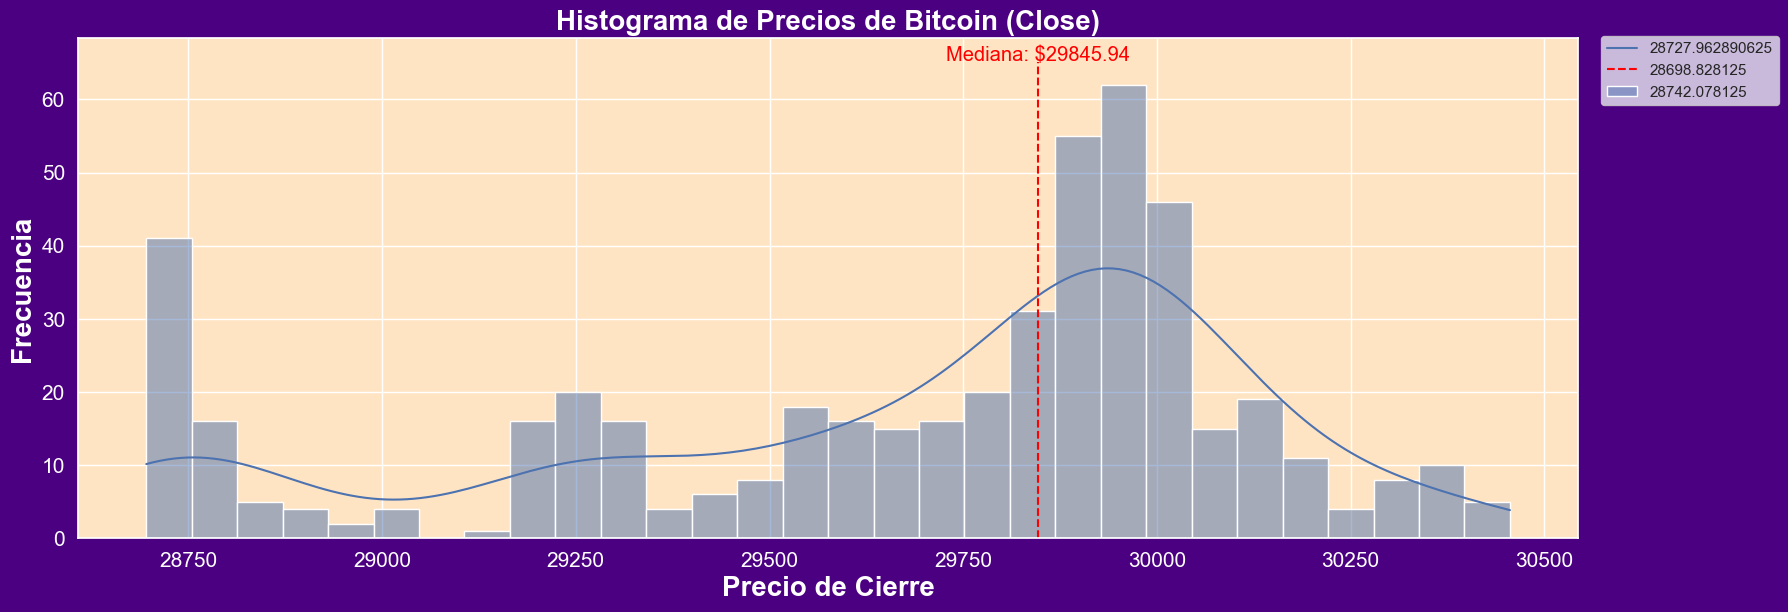

In [8]:
fig = plt.figure(figsize=(15, 5), facecolor='indigo')
eje = fig.add_axes([0, 0, 1, 1])
datos_limpios = limpieza_datos()[0]
close = datos_limpios['Close']
# eje.hist(close, bins=30, color='skyblue', edgecolor='black')
sns.histplot(data=datos_limpios, x=close,bins=30, kde=True);
mediana = close.median()
eje.vlines(x=mediana, ymin=0, ymax=eje.get_ylim()[1], color='red', linestyle='dashed', label='Mediana')
eje.set_title('Histograma de Precios de Bitcoin (Close)', fontsize=20, fontweight='bold', color='w')
eje.set_xlabel('Precio de Cierre', fontsize=20, fontweight='bold', color='w')
eje.set_ylabel('Frecuencia', fontsize=20, fontweight='bold', color='w')
eje.set_facecolor('bisque')
eje.tick_params(axis='x', colors='w', labelsize=15)
eje.tick_params(axis='y', colors='w', labelsize=15)
eje.annotate(f'Mediana: ${round(mediana, 2)}', xy=(mediana, eje.get_ylim()[1]-1.05), ha='center', va='top', color='red', fontsize=14.5)
plt.legend(close,bbox_to_anchor=(1.01, 1.02), loc='upper left')
plt.gray()
plt.show()

In [9]:
datos_limpios.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-18 04:55:00+00:00,28576.671875,28889.009766,28576.671875,28727.962891,236791808,0.0,0.0
2023-10-18 05:00:00+00:00,28735.289062,28752.898438,28698.828125,28698.828125,454347776,0.0,0.0
2023-10-18 05:05:00+00:00,28725.666016,28742.078125,28725.666016,28742.078125,135631872,0.0,0.0
2023-10-18 05:10:00+00:00,28741.804688,28741.804688,28701.523438,28701.523438,47966208,0.0,0.0
2023-10-18 05:25:00+00:00,28708.994141,28752.343750,28708.994141,28744.191406,76482560,0.0,0.0


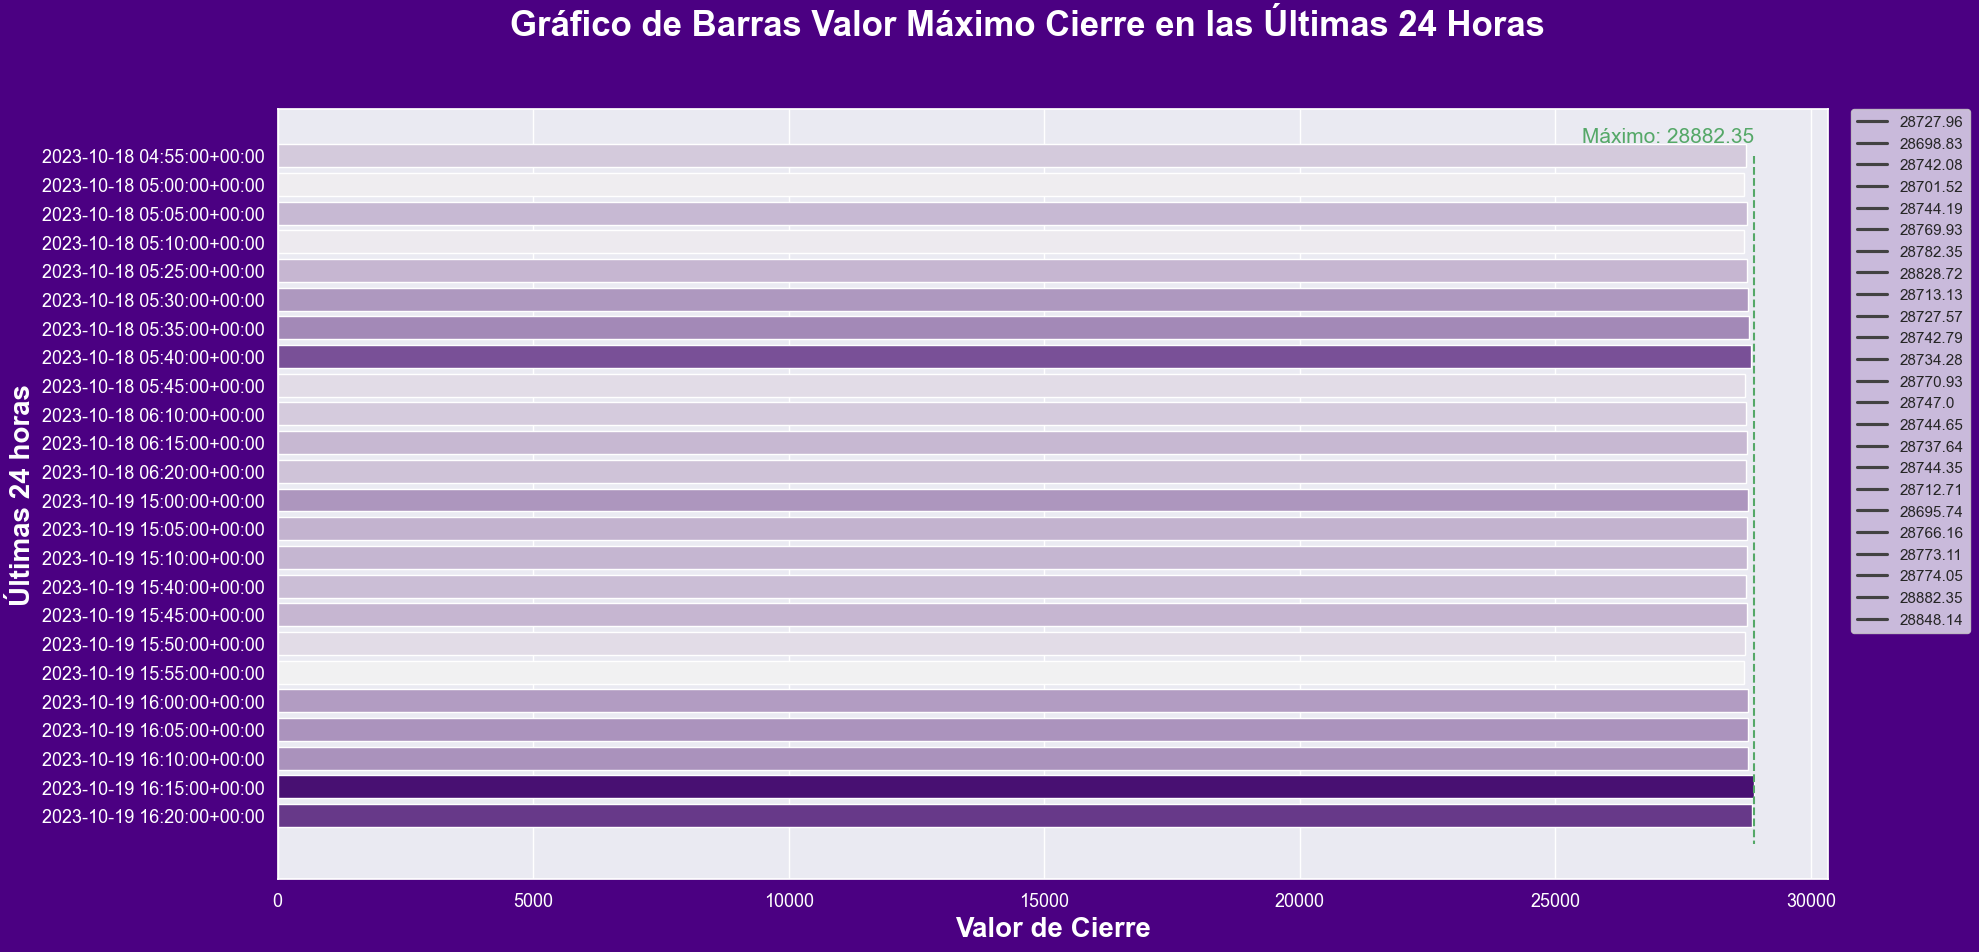

In [10]:
plt.figure(figsize=(20, 10), facecolor='indigo')
datos_limpios = limpieza_datos()[0]
close = datos_limpios['Close']
sns.barplot( data=datos_limpios.head(24), x='Close', y='Datetime', hue='Close', palette='light:indigo');
plt.suptitle('Gráfico de Barras Valor Máximo Cierre en las Últimas 24 Horas', color='w', fontsize=25, fontweight='bold')
plt.xlabel('Valor de Cierre',color='w', size=20, fontweight='bold')
plt.ylabel('Últimas 24 horas', color='w', size=20, fontweight='bold')
plt.tick_params(axis='x', colors='w', labelsize=13)
plt.tick_params(axis='y', colors='w',labelsize=13)
maximos = round(datos_limpios.head(24)[datos_limpios.head(24)['Close'] == datos_limpios.head(24)['Close'].max()], 2)
plt.vlines(x=maximos['Close'], ymin=0, ymax=len(datos_limpios.head(24)), colors='g', linestyles='dashed', label='Máximo')
for index, row in maximos.iterrows():
    plt.text(row['Close'], len(datos_limpios.head(24)) - 25, f'Máximo: {row["Close"]}', fontsize=15, ha='right', va='top', color='g')
plt.gray()
plt.legend(round(close.head(24), 2),bbox_to_anchor=(1.01, 1.01), loc='upper left')
plt.show()

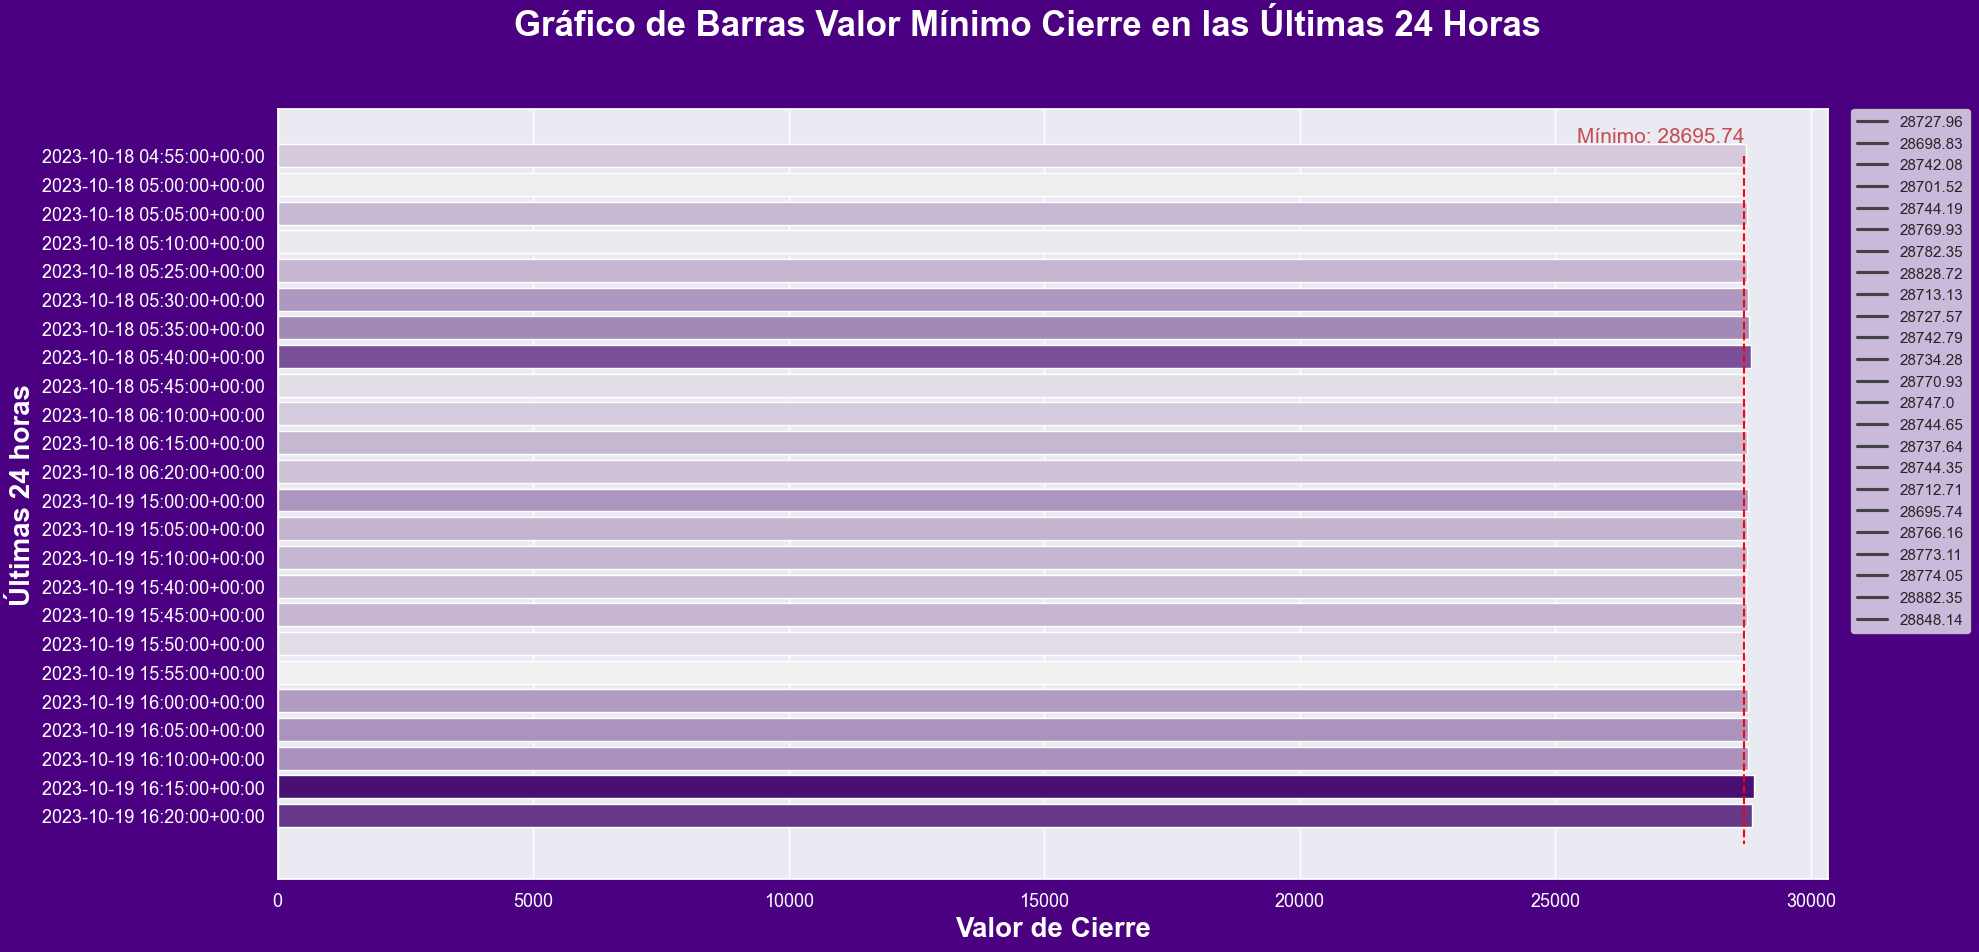

In [11]:
plt.figure(figsize=(20, 10), facecolor='indigo')
datos_limpios = limpieza_datos()[0]
close = datos_limpios['Close']

# sns.set(style="darkgrid")
sns.barplot( data=datos_limpios.head(24), x='Close', y='Datetime', hue='Close', palette='light:indigo');
plt.suptitle('Gráfico de Barras Valor Mínimo Cierre en las Últimas 24 Horas', color='w', fontsize=25, fontweight='bold')
plt.xlabel('Valor de Cierre',color='w', size=20, fontweight='bold')
plt.ylabel('Últimas 24 horas', color='w', size=20, fontweight='bold')
plt.tick_params(axis='x', colors='w', labelsize=13)
plt.tick_params(axis='y', colors='w',labelsize=13)
maximos = round(datos_limpios.head(24)[datos_limpios.head(24)['Close'] == datos_limpios.head(24)['Close'].min()], 2)
plt.vlines(x=maximos['Close'], ymin=0, ymax=len(datos_limpios.head(24)), colors='red', linestyles='dashed', label='Mínimos')
for index, row in maximos.iterrows():
    plt.text(row['Close'], len(datos_limpios.head(24)) - 25, f'Mínimo: {row["Close"]}', fontsize=15, ha='right', va='top', color='r')
plt.gray()
plt.legend(round(close.head(24), 2),bbox_to_anchor=(1.01, 1.01), loc='upper left')
plt.show()

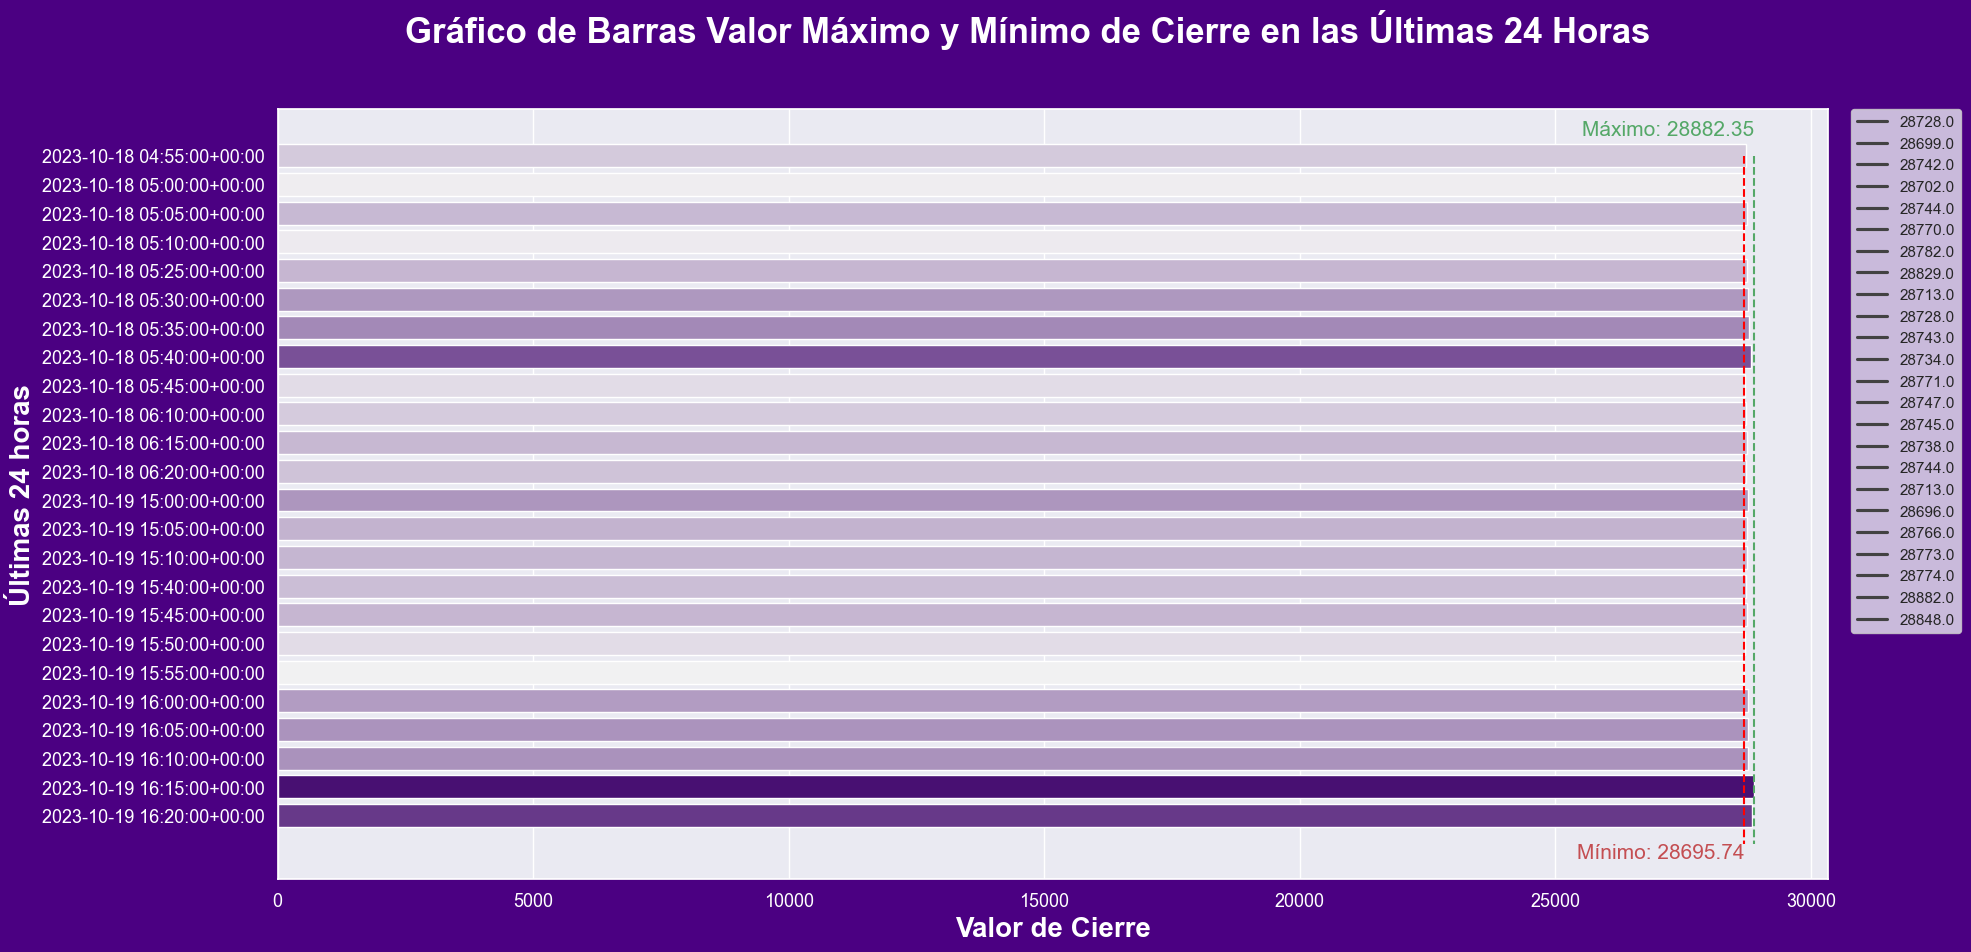

In [12]:
plt.figure(figsize=(20, 10), facecolor='indigo')
datos_limpios = limpieza_datos()[0]
close = datos_limpios['Close']
sns.barplot( data=datos_limpios.head(24), x='Close', y='Datetime', hue='Close', palette='light:indigo');
plt.suptitle('Gráfico de Barras Valor Máximo y Mínimo de Cierre en las Últimas 24 Horas', color='w', fontsize=25, fontweight='bold')
plt.xlabel('Valor de Cierre',color='w', size=20, fontweight='bold')
plt.ylabel('Últimas 24 horas', color='w', size=20, fontweight='bold')
plt.tick_params(axis='x', colors='w', labelsize=13)
plt.tick_params(axis='y', colors='w',labelsize=13)

maximo = round(datos_limpios.head(24)['Close'].max(), 2)
minimo = round(datos_limpios.head(24)['Close'].min(), 2)

plt.vlines(x=maximo, ymin=0, ymax=len(datos_limpios.head(24)), colors='g', linestyles='dashed', label='Máximos')
plt.vlines(x=minimo, ymin=0, ymax=len(datos_limpios.head(24)), colors='red', linestyles='dashed', label='Mínimos')

plt.text(maximo, len(datos_limpios.head(24)) - 25.25, f'Máximo: {maximo}', fontsize=15, ha='right', va='top', color='g')
plt.text(minimo, len(datos_limpios.head(24)) - 0.05, f'Mínimo: {minimo}', fontsize=15, ha='right', va='top', color='r')

plt.gray()
plt.legend(round(close.head(24)),bbox_to_anchor=(1.01, 1.01), loc='upper left')
plt.show()


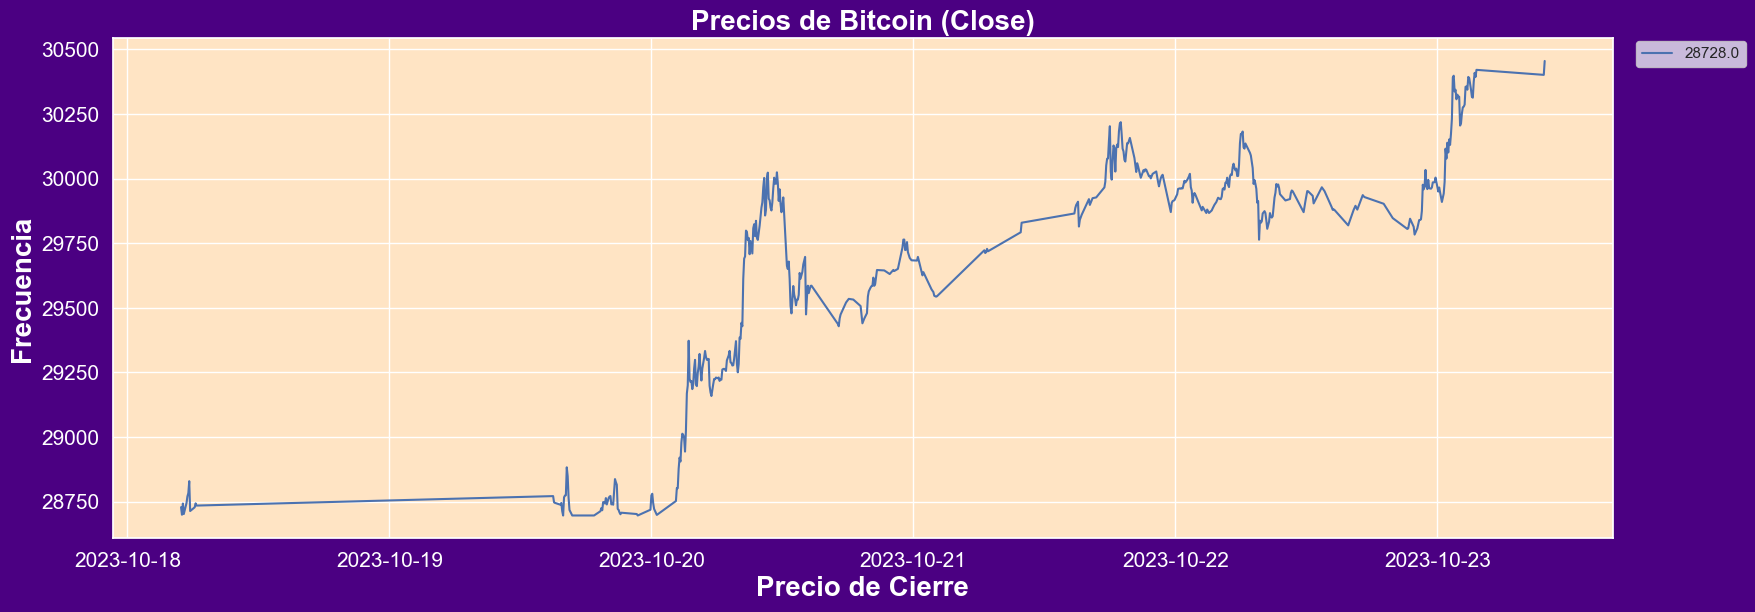

In [13]:
# sns.set(style="darkgrid")
fig = plt.figure(figsize=(15,5), facecolor='indigo')
eje = fig.add_axes([0,0,1,1])
eje.tick_params(axis='x', colors='w', labelsize=15)
eje.tick_params(axis='y', colors='w', labelsize=15)

datos_limpios = limpieza_datos()[0]
close = datos_limpios['Close']

eje.plot(close)
eje.set_title('Precios de Bitcoin (Close)', fontsize=20, fontweight='bold', color='w')
eje.set_xlabel('Precio de Cierre', fontsize=20, fontweight='bold', color='w')
eje.set_ylabel('Frecuencia', fontsize=20, fontweight='bold', color='w')
eje.set_facecolor('bisque')
plt.gray()
plt.legend(round(close.head(24)),bbox_to_anchor=(1.01, 1.01), loc='upper left')
plt.show()

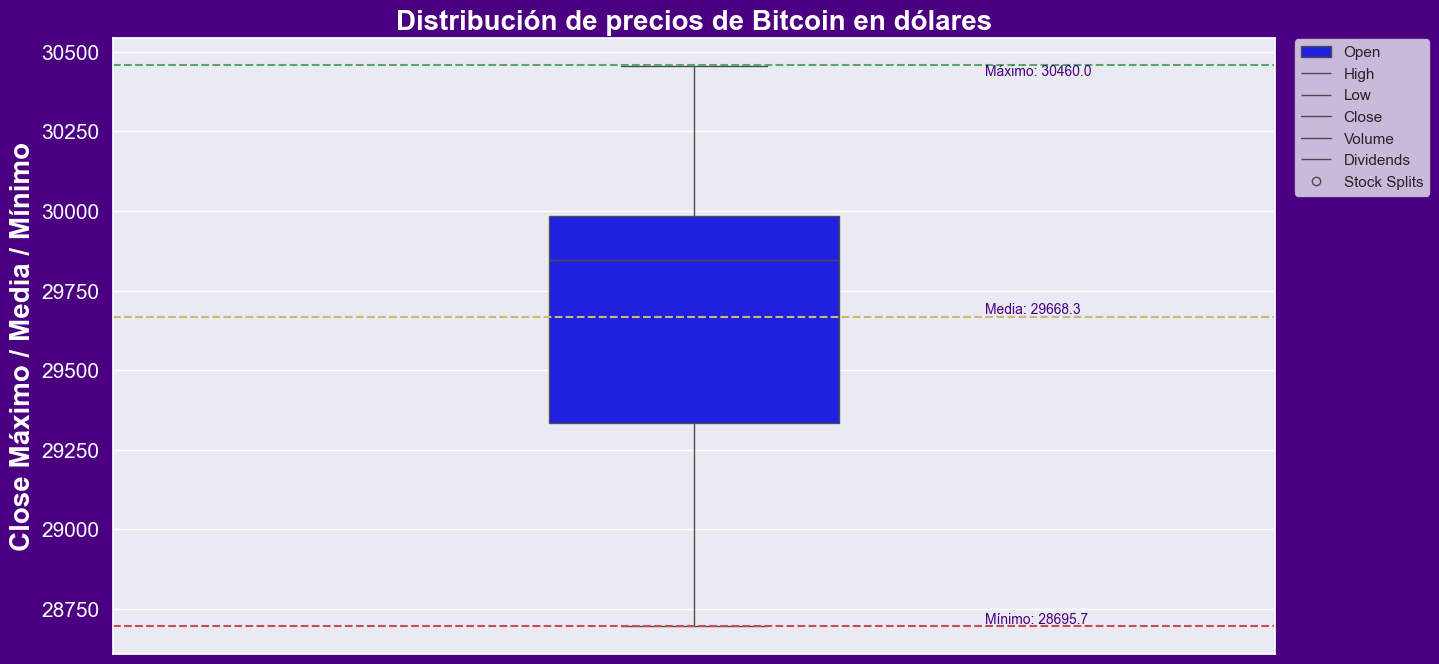

In [14]:
def boxplot1():
  # sns.set(style="darkgrid")
  plt.figure(figsize=(15, 8), facecolor='indigo')
  plt.tick_params(axis='x', colors='w', labelsize=15)
  plt.tick_params(axis='y', colors='w', labelsize=15)
 
  boxplot = sns.boxplot(y='Close', data=df_bitcoin_limpio, whis=2, width=0.25, color='blue')
  plt.title('Distribución de precios de Bitcoin en dólares', size=20, color='w',fontweight='bold')
  plt.ylabel(f'Close Máximo / Media / Mínimo', color='w',fontweight='bold', size=20)
  media = df_bitcoin_limpio['Close'].mean()
  maximo = limpieza_datos()[2]
  minimo = limpieza_datos()[1]

  boxplot.axhline(y=maximo, color='g', linestyle='--')
  boxplot.axhline(y=media, color='y', linestyle='--') 
  boxplot.axhline(y=minimo, color='r', linestyle='--') 
  
  plt.text(x=0.25, y=limpieza_datos()[2], s=f'Máximo: {limpieza_datos()[2].round(1)}', fontsize=10, va='top', color='indigo')
  plt.text(x=0.25, y=media, s=f'Media: {media.round(1)}', fontsize=10, va='bottom', color='indigo')
  plt.text(x=0.25, y=limpieza_datos()[1], s=f'Mínimo: {limpieza_datos()[1].round(1)}', fontsize=10, va='bottom', color='indigo')
  plt.gray()
  
  plt.legend(df_bitcoin_limpio,bbox_to_anchor=(1.01, 1.01), loc='upper left')
  return plt.show()

boxplot1()

4.Toma de desición Compra / Vanta / Espera

In [15]:
def tomar_decisiones():
  global df_bitcoin, precio_actual, media_bitcoin, algoritmo_decision, df_bitcoin_limpio
  media_bitcoin = df_bitcoin_limpio['Close'].mean()
  if ((precio_actual <= media_bitcoin) & (tendencia == 'baja')):
    algoritmo_decision = '-- Vender --'
  elif ((precio_actual > media_bitcoin) & (tendencia == 'alta')):
    algoritmo_decision = '-- Comprar --'
    return algoritmo_decision
  else:
    algoritmo_decision = '-- Esperar --'
  
  return algoritmo_decision
tomar_decisiones()



'-- Comprar --'

5.Visualizando los datos / Variación de los últimos 7 días

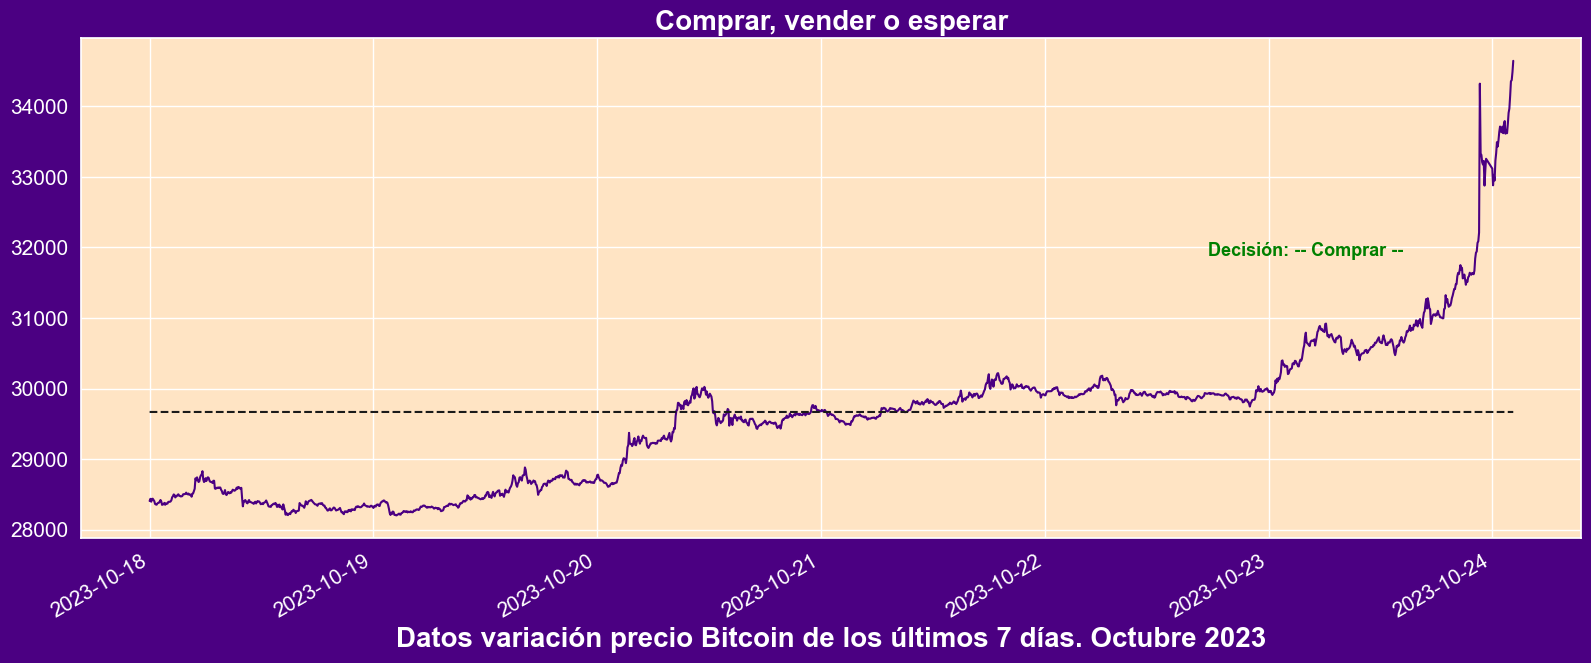

In [16]:
def visualizacion():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, df_bitcoin_limpio
  df_bitcoin['Promedio'] = media_bitcoin

  # sns.set(style="whitegrid")
  fig = plt.figure(figsize=(15,5), facecolor='indigo')
  eje = fig.add_axes([0,0,1,1])
  eje.tick_params(axis='x', colors='w', labelsize=15)
  eje.tick_params(axis='y', colors='w', labelsize=15)
  
  eje.set_title('Comprar, vender o esperar', fontsize=20,fontweight='bold', color='w')
  df_bitcoin['Close'].plot(legend = None, color = 'indigo')
  df_bitcoin['Promedio'].plot(legend = None, ls='--', color = 'k', fontsize=15)
  

  eje.set_xlabel('Datos variación precio Bitcoin de los últimos 7 días. Octubre 2023', fontsize=20, fontweight='bold', color='w')
  eje.set_facecolor('bisque')
  eje.annotate(f'Decisión: {algoritmo_decision}', xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), xytext=(-220, -140), textcoords='offset points', fontsize=13, color='green',fontweight='bold')
  plt.gray()
  plt.show()
  
visualizacion()

6.Automatizamos el sistema 

Hora de verificación: 23:17:35
Ejecuciones: 1
Decisión: -- Comprar --
Tendencia: alta
Media: 29668
Precio: 34522


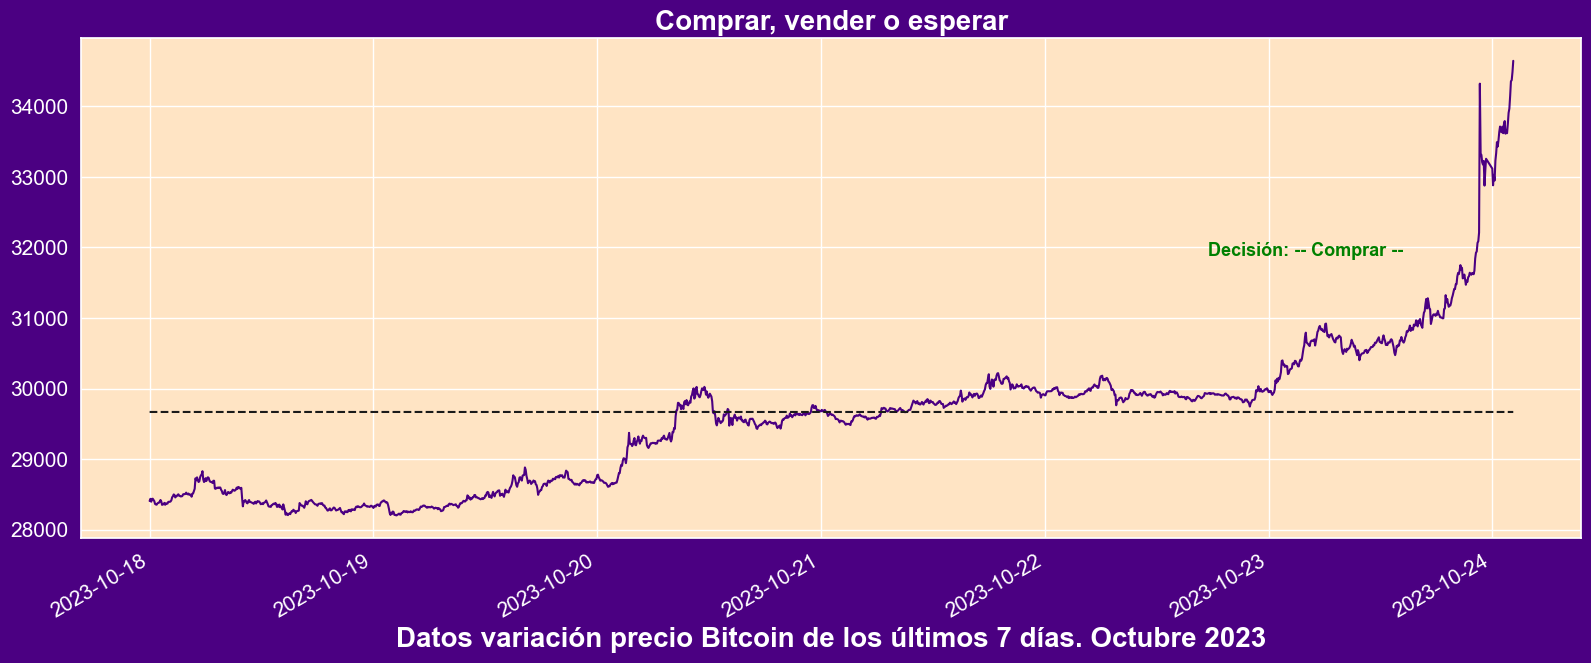

In [17]:
  
def automatizado(): 
  contador = 0 
  while True:
    contador += 1
    clear_output(wait=True)
    importar_base_bitcoin()
    extraer_tendencias()
    limpieza_datos()
    tomar_decisiones()
    tz = pytz.timezone('America/Argentina/Buenos_Aires')
    now = datetime.datetime.now(tz)
    print("Hora de verificación:", now.strftime("%H:%M:%S"))
    print(f'Ejecuciones: {contador}')
    print('Decisión:', tomar_decisiones()),print('Tendencia:',tendencia),print('Media:',int(media_bitcoin)),print('Precio:',int(precio_actual))
    visualizacion()
    time.sleep(300)
    
    
    
automatizado()
  
  


La toma de datos de variación de precio del bitcoin de los últimos 7 días es un proceso que consiste en recopilar información sobre el precio del bitcoin en un período de tiempo determinado. Esta información se puede utilizar para realizar análisis de tendencias y proyecciones del precio futuro de la moneda.
En nuestro caso para la toma de desiciones de Compra / Venta / Espera según situación y conveniencia.
Web scraping: Este método permite extraer datos de una página web utilizando un script o programa.
Una vez que se han recopilado los datos, se pueden almacenar en una base de datos o en un archivo CSV. Los datos se pueden analizar utilizando una variedad de herramientas y técnicas, como hojas de cálculo, software de análisis de datos y lenguajes de programación.
Una vez que se han recopilado los datos, se pueden analizar para obtener información sobre la variación de precio del bitcoin de los últimos 7 días. Por ejemplo, se puede calcular el rendimiento diario del bitcoin o el porcentaje de variación de precio del bitcoin en un período de tiempo determinado.